# BERT Prediction Error Analysis

As the result of text classification by 3 types of BERT models ( BERT_BASED_UNCASED, BERT_LARGE_UNCASED, DISTILBERT), it is found that:
 - The smaller the model is, the higher the accuracies. Distilbert achieved 77.8% in contrast that Bert_large_uncased only achieved 70& around.

In order to improve the accuracy level, we will perform the further study on those records whose prediction result are wrong, and see whether there are some ways.

Given Bert_large_uncased does not achieved high accuracy, in order to save the potential efforts, we take the remaining 2 models for the error analysis.

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [2]:
import torch
#Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE=1
#################### split data into train,dev,test##################
def train_dev_test(dataset,random_state=RANDOM_STATE):
    texts=list(dataset["original_text"])
    labels=list(dataset["label"])
    
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    print(label2idx)

    rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=RANDOM_STATE)
    train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=RANDOM_STATE)

    print("Train size:", len(train_texts))
    print("Dev size:", len(dev_texts))
    print("Test size:", len(test_texts))
    return (train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)

In [4]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
import numpy as np
#################### Both class and the following function are used to prepare for input items##################

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items


In [6]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

#################### convert data for model input ##################

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    #dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    # dataloader tuning in https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
   
    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size,num_workers=2,pin_memory=True)
    return dataloader

In [7]:
from tqdm import trange
from tqdm.notebook import tqdm

def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            #tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
            #                              token_type_ids=segment_ids, labels=label_ids)[:2]
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                         labels=label_ids)[:2]  # for distilbert
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [8]:
import os
from tqdm import trange
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers import AdamW,get_linear_schedule_with_warmup


def train(model_name,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params):
    
    
    ## Initialize bert model   
    tokenizer = DistilBertTokenizer.from_pretrained(model_name,target_names=target_names)
    # Using trained model
    model=DistilBertForSequenceClassification.from_pretrained(model_name,num_labels = len(target_names),
                                                             output_attentions = False,
                                                             output_hidden_states = False)  
    
    ## Prepare for data loading and parameter setting for bert model
    train_features = convert_examples_to_inputs(train_texts,train_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
    train_dataloader = get_data_loader(train_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)
    dev_features = convert_examples_to_inputs(dev_texts,dev_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
    dev_dataloader = get_data_loader(dev_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)

    num_train_steps = int(len(train_dataloader.dataset) / params['BATCH_SIZE'] /params['GRADIENT_ACCUMULATION_STEPS'] * params['NUM_TRAIN_EPOCHS'])
    num_warmup_steps = params['NUM_WARMUP_STEPS']

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=params['LEARNING_RATE'], correct_bias=False)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,num_training_steps=num_train_steps)
    
    ##Enable GPU if has
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    ## Start to training 
    torch.backends.cudnn.benchmark = True # tuning guide:https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

    loss_history = []
    no_improvement = 0
    PATIENCE=2
    for _ in trange(int(params["NUM_TRAIN_EPOCHS"]), desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            #outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids) # non-distillbert
            outputs = model(input_ids, attention_mask=input_mask,labels=label_ids)
            loss = outputs[0]

            if params['GRADIENT_ACCUMULATION_STEPS'] > 1:
                loss = loss / params['GRADIENT_ACCUMULATION_STEPS']

            loss.backward()
            tr_loss += loss.item()

            if (step + 1) % params['GRADIENT_ACCUMULATION_STEPS'] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(),params['MAX_GRAD_NORM'])  

                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()
        dev_loss, _, _ = evaluate(model, dev_dataloader)
            #print("Dev loss:", dev_loss)
    
        print("Loss history:", loss_history)
        print("Dev loss:", dev_loss)

        if len(loss_history) == 0 or dev_loss < min(loss_history):
            no_improvement = 0
            model_to_save = model.module if hasattr(model, 'module') else model
            output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            no_improvement += 1

        if no_improvement >= PATIENCE: 
            print("No improvement on development set. Finish training.")
            break


        loss_history.append(dev_loss)
    

In [9]:
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification
from transformers import BertTokenizer,DistilBertTokenizer
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "./tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"


# Evaluate the dataset based on trained distilbert model
def data_evaluation(texts,labels,model_name,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME):
    # Convert test data of submission to features
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    
    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select bert model
    #BERT_MODEL = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
       
    if trained:
        # Using trained model
        model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
        model=DistilBertForSequenceClassification.from_pretrained(model_name, state_dict=model_state_dict, num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)
    else:
        # Using pretrained model without training
        model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL,num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)        
    model.to(device)
    
    # Convert text and labels to embeddings 
    features = convert_examples_to_inputs(texts, labels, label2idx,  params['MAX_SEQ_LENGTH'], tokenizer)
    dataloader = get_data_loader(features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=False)
    
    # Predict the result, and discard the evaluatoin result, only take the prediction result.
    _, correct, predicted = evaluate(model, dataloader)
    print("Errors performance:", precision_recall_fscore_support(correct, predicted, average="micro"))

    bert_accuracy = np.mean(predicted == correct)
    
    #print(bert_accuracy)
    print(classification_report(correct, predicted))

    return correct,predicted, bert_accuracy 

##### Import dataset

In [10]:
import pandas as pd
# load train data
source_train_data_path="./01_data/WikiLarge_Train.csv"
source_train_data=pd.read_csv(source_train_data_path)

RANDOM_STATE=1
PORTION=0.2
size=round(len(source_train_data)*PORTION)
train_data=source_train_data.sample(n=size,random_state=RANDOM_STATE)

Text(0.5, 0, 'length')

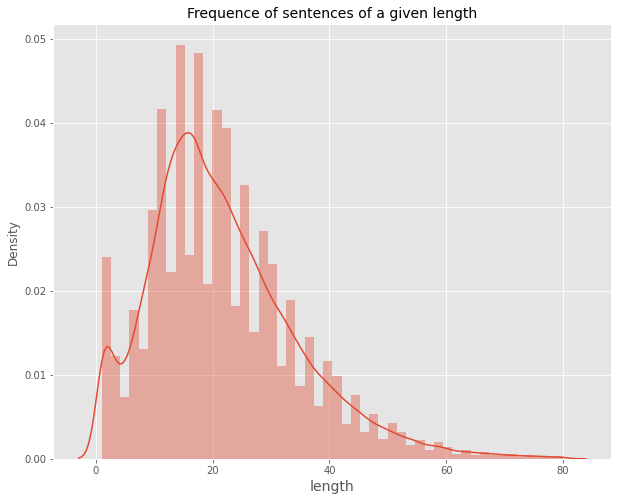

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_data['length'] = train_data['original_text'].apply(lambda x: len(x.split()))
sns.distplot(train_data[train_data['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [12]:
# BERT token length should not be more than 512.
data_describe=train_data['original_text'].apply(lambda x: len(x.split())).describe()
print(data_describe)
MAX_SEQ_LENGTH=int(data_describe['max'])
if MAX_SEQ_LENGTH>512:
    MAX_SEQ_LENGTH=512

count    83354.000000
mean        21.850565
std         12.705665
min          1.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         80.000000
Name: original_text, dtype: float64


In [13]:

(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(train_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 67516
Dev size: 7502
Test size: 8336


In [14]:
params={
        "GRADIENT_ACCUMULATION_STEPS":1,
        "NUM_TRAIN_EPOCHS":8,
        "LEARNING_RATE":2e-5,
        "WARMUP_PROPORTION":0.1,
        "MAX_GRAD_NORM":5,
        "MAX_SEQ_LENGTH":MAX_SEQ_LENGTH,
        "BATCH_SIZE":16,
        "NUM_WARMUP_STEPS":600
}
BERT_MODEL = "distilbert-base-uncased"

##### Initial accuracy for pretrain model

In [15]:
_,init_pred,init_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=False,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Evaluation iteration:   0%|          | 0/521 [00:00<?, ?it/s]

Errors performance: (0.5011996161228407, 0.5011996161228407, 0.5011996161228407, None)
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4178
           1       0.00      0.00      0.00      4158

    accuracy                           0.50      8336
   macro avg       0.25      0.50      0.33      8336
weighted avg       0.25      0.50      0.33      8336



C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1248

##### Train model without any preprocessing.

In [16]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.500582580659181


Epoch:  12%|█████████▎                                                                | 1/8 [12:59<1:30:55, 779.32s/it]

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▌                                                       | 2/8 [26:19<1:19:08, 791.47s/it]

Loss history: [0.500582580659181]
Dev loss: 0.5083669773551193


Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▎                                                      | 2/8 [39:22<1:58:08, 1181.35s/it]

Loss history: [0.500582580659181, 0.5083669773551193]
Dev loss: 0.6569554694394059
No improvement on development set. Finish training.


##### Accuracy after training

In [17]:
_,orig_pred,orig_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/521 [00:00<?, ?it/s]

Errors performance: (0.7396833013435701, 0.7396833013435701, 0.7396833013435701, None)
              precision    recall  f1-score   support

           0       0.78      0.68      0.72      4178
           1       0.71      0.80      0.75      4158

    accuracy                           0.74      8336
   macro avg       0.74      0.74      0.74      8336
weighted avg       0.74      0.74      0.74      8336



##### Remove stopwords

In [18]:
from text_preprocessing import preprocess_text
from text_preprocessing import remove_punctuation,remove_special_character,normalize_unicode,check_spelling,remove_stopword,lemmatize_word
# Preprocess text using custom preprocess functions in the pipeline 
#STOPWORDS=['-RRB-','-LRB-'] # remove customized stopwords
#preprocess_functions = [to_lower, remove_punctuation,remove_special_character,normalize_unicode,remove_stopword,lemmatize_word]


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(remove_stopword(x)))

In [20]:
process_data

,original_text,label,length
314316,"The Yarra Trams fleet consists 500 trams , ope...",0,18
136396,"Still Life concept album , explained Åkerfeldt...",1,39
377680,"Romana , short Romanadvoratrelundar , fictiona...",0,20
280270,A minor scale music theory scale least three s...,0,35
285587,The show also created character Frasier Crane .,0,9
...,...,...,...
315430,Eschlikon municipality district MÃ 1\/4 nchwil...,0,19
220505,"More recently , appeared Mario & Luigi : Partn...",0,45
333022,# NAME ?,0,1
49917,"Little known Mario 's childhood , though infan...",1,44


In [21]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 67516
Dev size: 7502
Test size: 8336


In [22]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.5163188167472383


Epoch:  12%|█████████▎                                                                | 1/8 [13:06<1:31:42, 786.03s/it]

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▌                                                       | 2/8 [27:16<1:22:23, 823.84s/it]

Loss history: [0.5163188167472383]
Dev loss: 0.5234313742247726


Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▎                                                      | 2/8 [41:42<2:05:06, 1251.05s/it]

Loss history: [0.5163188167472383, 0.5234313742247726]
Dev loss: 0.688323478613581
No improvement on development set. Finish training.


In [23]:
_,sw_pred,sw_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/521 [00:00<?, ?it/s]

Errors performance: (0.7279270633397313, 0.7279270633397313, 0.7279270633397313, None)
              precision    recall  f1-score   support

           0       0.76      0.66      0.71      4178
           1       0.70      0.79      0.74      4158

    accuracy                           0.73      8336
   macro avg       0.73      0.73      0.73      8336
weighted avg       0.73      0.73      0.73      8336



##### Spelling correction 

In [24]:
type('dfdf')

str

In [25]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(check_spelling(x)) if type(x)=='str' else x)

In [26]:
process_data

,original_text,label,length
314316,"The Yarra Trams fleet consists of 500 trams , ...",0,18
136396,"Still Life is a concept album , as explained b...",1,39
377680,"Romana , short for Romanadvoratrelundar , is a...",0,20
280270,A minor scale in music theory is any scale tha...,0,35
285587,The show also created the character Frasier Cr...,0,9
...,...,...,...
315430,Eschlikon is a municipality of the district of...,0,19
220505,"More recently , he has appeared in Mario & Lui...",0,45
333022,#NAME?,0,1
49917,"Little is known of Mario 's childhood , though...",1,44


In [27]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 67516
Dev size: 7502
Test size: 8336


In [28]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.5007374003561321


Epoch:  12%|█████████▎                                                                | 1/8 [14:26<1:41:02, 866.07s/it]

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▌                                                       | 2/8 [28:56<1:26:52, 868.69s/it]

Loss history: [0.5007374003561321]
Dev loss: 0.5207683325512831


Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▎                                                      | 2/8 [43:27<2:10:23, 1303.86s/it]

Loss history: [0.5007374003561321, 0.5207683325512831]
Dev loss: 0.6544239296397166
No improvement on development set. Finish training.


In [29]:
_,pc_pred,pc_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/521 [00:00<?, ?it/s]

Errors performance: (0.7384836852207294, 0.7384836852207294, 0.7384836852207294, None)
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4178
           1       0.74      0.73      0.74      4158

    accuracy                           0.74      8336
   macro avg       0.74      0.74      0.74      8336
weighted avg       0.74      0.74      0.74      8336



##### Lemmatization 

In [30]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(lemmatize_word(x)))

In [31]:
process_data['original_text']

314316    The Yarra Trams fleet consists of 500 tram , o...
136396    Still Life is a concept album , a explained by...
377680    Romana , short for Romanadvoratrelundar , is a...
280270    A minor scale in music theory is any scale tha...
285587    The show also created the character Frasier Cr...
                                ...                        
315430    Eschlikon is a municipality of the district of...
220505    More recently , he ha appeared in Mario & Luig...
333022                                             # NAME ?
49917     Little is known of Mario 's childhood , though...
180203    MÃ zÃ riat is a commune in the Ain department ...
Name: original_text, Length: 83354, dtype: object

In [32]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 67516
Dev size: 7502
Test size: 8336


In [33]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.49892296278273374


Epoch:  12%|█████████▎                                                                | 1/8 [13:49<1:36:43, 829.01s/it]

Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▌                                                       | 2/8 [28:18<1:25:17, 852.98s/it]

Loss history: [0.49892296278273374]
Dev loss: 0.5064780548818584


Training iteration:   0%|          | 0/4220 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▎                                                      | 2/8 [42:47<2:08:21, 1283.59s/it]

Loss history: [0.49892296278273374, 0.5064780548818584]
Dev loss: 0.6614332108387052
No improvement on development set. Finish training.


In [34]:
_,lm_pred,lm_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/521 [00:00<?, ?it/s]

Errors performance: (0.7401631477927063, 0.7401631477927063, 0.7401631477927062, None)
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      4178
           1       0.72      0.78      0.75      4158

    accuracy                           0.74      8336
   macro avg       0.74      0.74      0.74      8336
weighted avg       0.74      0.74      0.74      8336



##### Check the duplicated data and create the data set without duplicates

In [35]:
train_data_unique=train_data.copy()
train_data_unique['duplicated']=train_data_unique.duplicated(subset=['original_text'])
#train_data_unique=train_data[train_data['duplicated']==False]
#print("Duplicated records: %.2f%%" %(100*(len(train_data)-len(train_data_unique))/len(train_data)))

In [36]:
train_data_unique

,original_text,label,length,duplicated
314316,"The Yarra Trams fleet consists of 500 trams , ...",0,18,False
136396,"Still Life is a concept album , as explained b...",1,39,False
377680,"Romana , short for Romanadvoratrelundar , is a...",0,20,False
280270,A minor scale in music theory is any scale tha...,0,35,False
285587,The show also created the character Frasier Cr...,0,9,False
...,...,...,...,...
315430,Eschlikon is a municipality of the district of...,0,19,False
220505,"More recently , he has appeared in Mario & Lui...",0,45,False
333022,#NAME?,0,1,True
49917,"Little is known of Mario 's childhood , though...",1,44,False


In [37]:
process_data=train_data_unique.copy()
process_data=process_data[(process_data['duplicated']==False)]

In [38]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 63375
Dev size: 7042
Test size: 7825


In [39]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Training iteration:   0%|          | 0/3961 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/441 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.5313373341852304


Epoch:  12%|█████████▎                                                                | 1/8 [13:33<1:34:52, 813.21s/it]

Training iteration:   0%|          | 0/3961 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▌                                                       | 2/8 [27:09<1:21:28, 814.77s/it]

Loss history: [0.5313373341852304]
Dev loss: 0.5617470427705588


Training iteration:   0%|          | 0/3961 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/441 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▎                                                      | 2/8 [40:45<2:02:15, 1222.65s/it]

Loss history: [0.5313373341852304, 0.5617470427705588]
Dev loss: 0.705081784282547
No improvement on development set. Finish training.


In [40]:
_,dup_pred,dup_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/490 [00:00<?, ?it/s]

Errors performance: (0.734185303514377, 0.734185303514377, 0.734185303514377, None)
              precision    recall  f1-score   support

           0       0.78      0.64      0.70      3843
           1       0.70      0.83      0.76      3982

    accuracy                           0.73      7825
   macro avg       0.74      0.73      0.73      7825
weighted avg       0.74      0.73      0.73      7825



##### Remove the records which have the different labels
The sentences with different labels should impact the train performance as well as prediction results 

In [41]:
# look for the records with different labels 
def duple_labels(data):
    df_by=pd.DataFrame(data.groupby(['original_text','label']).count().reset_index()[["original_text","label"]])
    df_by=df_by.groupby(by='original_text').count().sort_values('label',ascending=False).reset_index()
    diff_labels=df_by[df_by['label']>1]
    print("Records with different labels: %.2f%%" %(100*len(diff_labels)/len(data)))
    return diff_labels

In [42]:
df_duple_labels=duple_labels(train_data)

Records with different labels: 0.15%


In [43]:
# Indentify double labels in data
train_data_unique=train_data_unique.merge(df_duple_labels,how="left",left_on="original_text",right_on="original_text")
train_data_unique['label_y']=train_data_unique['label_y'].apply(lambda x: '0' if pd.isnull(x) else '1') # 0 means 1 label, 1 means 2 labels
train_data_unique=pd.DataFrame(train_data_unique[['original_text','label_x','label_y','duplicated']])
train_data_unique.columns=['original_text','label','dulabel','duplicated']

In [44]:
train_data_unique

,original_text,label,dulabel,duplicated
0,"The Yarra Trams fleet consists of 500 trams , ...",0,0,False
1,"Still Life is a concept album , as explained b...",1,0,False
2,"Romana , short for Romanadvoratrelundar , is a...",0,0,False
3,A minor scale in music theory is any scale tha...,0,0,False
4,The show also created the character Frasier Cr...,0,0,False
...,...,...,...,...
83349,Eschlikon is a municipality of the district of...,0,0,False
83350,"More recently , he has appeared in Mario & Lui...",0,0,False
83351,#NAME?,0,1,True
83352,"Little is known of Mario 's childhood , though...",1,0,False


##### Accuracy of removing records with duplicate text or different label

In [45]:
process_data=train_data_unique.copy()
process_data=process_data[(process_data['dulabel']=='0')]

In [46]:
process_data

,original_text,label,dulabel,duplicated
0,"The Yarra Trams fleet consists of 500 trams , ...",0,0,False
1,"Still Life is a concept album , as explained b...",1,0,False
2,"Romana , short for Romanadvoratrelundar , is a...",0,0,False
3,A minor scale in music theory is any scale tha...,0,0,False
4,The show also created the character Frasier Cr...,0,0,False
...,...,...,...,...
83348,"Other names of the language are Kamtapuri , Ra...",0,0,True
83349,Eschlikon is a municipality of the district of...,0,0,False
83350,"More recently , he has appeared in Mario & Lui...",0,0,False
83352,"Little is known of Mario 's childhood , though...",1,0,False


In [47]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 67227
Dev size: 7470
Test size: 8300


In [48]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

Training iteration:   0%|          | 0/4202 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/467 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.5020531826598741


Epoch:  12%|█████████▎                                                                | 1/8 [14:20<1:40:26, 860.93s/it]

Training iteration:   0%|          | 0/4202 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/467 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▌                                                       | 2/8 [30:09<1:31:14, 912.49s/it]

Loss history: [0.5020531826598741]
Dev loss: 0.5204251364064931


Training iteration:   0%|          | 0/4202 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/467 [00:00<?, ?it/s]

Epoch:  25%|██████████████████▎                                                      | 2/8 [45:55<2:17:47, 1377.90s/it]

Loss history: [0.5020531826598741, 0.5204251364064931]
Dev loss: 0.6566305533211032
No improvement on development set. Finish training.


In [49]:
_,duo_pred,duo_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/519 [00:00<?, ?it/s]

Errors performance: (0.7508433734939759, 0.7508433734939759, 0.7508433734939759, None)
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      4154
           1       0.73      0.80      0.76      4146

    accuracy                           0.75      8300
   macro avg       0.75      0.75      0.75      8300
weighted avg       0.75      0.75      0.75      8300



##### Compare the results from different text processing

In [50]:
df_acc=pd.DataFrame(columns=['description','accuracy'])
df_acc['description']=['Pretrain','Fine tune without preprocessing',
                       'Removal of stopwords','Correction of spelling',
                      'Lemmatization','Removal of duplicate records',
                      'Removal of mislabeling']
df_acc['accuracy']=[init_acc,orig_acc,sw_acc,pc_acc,lm_acc,dup_acc,duo_acc]

<AxesSubplot:xlabel='accuracy', ylabel='description'>

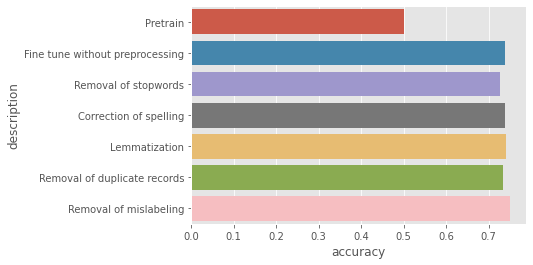

In [51]:
sns.barplot(data=df_acc, y="description", x="accuracy")

##### Impact investigation on similar text

In [52]:
df_test=pd.DataFrame(columns=['original_text','label','err','init_pred','best_pred','cnt_1','cnt_0','avg_1','avg_0'])

In [53]:
df_test['original_text']=test_texts
df_test['label']=test_labels
df_test['init_pred']=init_pred
df_test['best_pred']=orig_pred
df_test['err']=df_test['best_pred']-df_test['label']
df_test['err']=df_test['err'].apply(lambda x: 1 if x!=0 else x)

ValueError: Length of values (8336) does not match length of index (8300)

In [ ]:
df_test

##### Display the length of test data and error data in test set

In [ ]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df_test['length'] = df_test['original_text'].apply(lambda x: len(x.split()))
sns.distplot(df_test[df_test['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [ ]:
sns.distplot(df_test[(df_test['length'] < 5000) & (df_test['err']==1)]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [ ]:
from bertopic import BERTopic

from transformers.pipelines import pipeline

#sentence_model = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens", device="cuda")
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
#topics, probs = topic_model.fit_transform(train_data['original_text'])

In [ ]:
# topics for error data
test_topics, test_probs = topic_model.fit_transform(df_test['original_text'])

In [ ]:
topic_model.topic_sizes_

In [ ]:
topic_model.visualize_documents(df_test['original_text'])

In [ ]:
df_test['topics']=test_topics

In [ ]:
df_test[df_test['length']<=4]

In [ ]:
from sentence_transformers import SentenceTransformer
onlinemodel='all-mpnet-base-v2'
embedder = SentenceTransformer(onlinemodel)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# work out the similarity and identify the record of self
str_to_predict=df_test['original_text'].iloc[11]
print(str_to_predict)
query_embeddings=embedder.encode(df_test['original_text'])
sim=cosine_similarity([embedder.encode(str_to_predict)],query_embeddings)
j=np.argmax(sim)
#sim.argsort()[-3:][::-1][0][:-1]

In [ ]:
df_test=df_test.reset_index()

In [ ]:
err_cluster=pd.DataFrame(columns=list(df_test.columns)+['cluster'])

In [ ]:
err_cluster

In [ ]:
query_embeddings=embedder.encode(df_test['original_text'])
THRESHOLD=0.5
for i in trange(len(df_test[df_test['err']==1])):
    #print(df_test[df_test['err']==1]['original_text'].iloc[i])
    df_temp=pd.DataFrame(columns=list(df_test.columns)+['cluster'])
    str_to_predict=df_test[df_test['err']==1]['original_text'].iloc[i]
    #print(str_to_predict)
    sim=cosine_similarity([embedder.encode(str_to_predict)],query_embeddings)
    j=np.argmax(sim)
    if np.where(sim[0]>THRESHOLD)[0] !=[]:
        print(set(np.where(sim[0]>THRESHOLD)[0]))
        print(set(err_cluster['index']))
        if err_cluster.empty:
            df_temp=df_test.iloc[np.where(sim[0]>THRESHOLD)[0]]
        else:
            df_temp=df_test.iloc[set(np.where(sim[0]>THRESHOLD)[0])-set(err_cluster['index'])]
        print(df_temp)
        if df_temp.empty== False:
            df_temp['cluster']=j
            err_cluster=pd.concat([err_cluster,df_temp],axis=1)

In [ ]:
df_test.iloc[np.where(sim[0]>0.2)[0]]

In [ ]:
# produce the fine tuning dataset
f_texts=[]
f_labels=[]
f_ind=[]
for i in np.where(sim[0]>0.4)[0]:
    if i!=j:
        f_texts.append(df_test.iloc[i]['original_text'])
        f_labels.append(df_test.iloc[i]['label'])
        f_ind.append(i)
    #print(i,train_data.iloc[i]['label'].values,train_data.iloc[i]['original_text'].values,sim[0][i])

In [ ]:
f_ind

In [ ]:
for i in f_ind:
    print(df_test.iloc[i])

In [ ]:
# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

In [ ]:
# Run Elbow for full training data
elbow_plot(query_embeddings,maxK=10)

In [ ]:
num_clusters = 5
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":i,
                                "sentence":df_test.iloc[i]['original_text']
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

In [ ]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(query_embeddings)

df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence_id']=df_test.index
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [ ]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k["cluster_id"])
#ls_colors=df_k["cluster_id"].astype('category').cat.codes
for id in range(len(ls_clusters)):
    ax.scatter(df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 2'],label=ls_clusters[id],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                            metric='cosine').fit_transform(query_embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
import matplotlib.pyplot as plt

# Prepare data
#umap_data = umap.UMAP(n_neighbors=2, n_components=2, min_dist=0.0, metric='cosine').fit_transform(query_embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=3)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=3, cmap='hsv_r')
plt.colorbar()

In [ ]:
result[(result['x']<5)&(result['y']<1.8)]